<a href="https://colab.research.google.com/github/fberetta8/ML_in_Finance_Spring_2025_ETH/blob/main/Solution4_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Credits for this exercise to [Tengyingzi (Sophia) Perrin](https://people-new.math.ethz.ch/~tengma/about ), who taught the class in FS24.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as s
import torch

# **European call option in BS model**  
A **European option** is a type of financial derivative that can only be exercised at its expiration date, and not before. We describe here a **call option**, meaning that one acquires the right to buy at a fixed price (strike).  This is different from an **American option**, which can be exercised at any time before expiration.  

In [2]:
class EuropeanCallOption(object):
    def __init__(self, S0, K, r, T, sigma, M, I):
        """
        Parameters:
        S0 : Initial stock price
        K : Strike price
        r : Risk-free interest rate
        T : Time to maturity
        sigma : Volatility
        M : Number of time steps for simulation
        I : Number of simulation paths (Monte Carlo simulations)
        """
        self.S0 = S0
        self.K = K
        self.r = r
        self.T = T
        self.sigma = sigma
        self.M = M
        self.I = I

    def value(self):
        """
        Compute the theoretical Black-Scholes price of the European call option.

        Uses the Black-Scholes formula:
        C = S0 * N(d1) - K * e^(-rT) * N(d2)
        where:
        d1 = (ln(S0/K) + (r + 0.5 * sigma^2) * T) / (sigma * sqrt(T))
        d2 = d1 - sigma * sqrt(T)

        Returns:
        Black-Scholes price of the option
        """
        d1 = (np.log(self.S0 / self.K) + (self.r + 0.5 * self.sigma ** 2) * self.T) / (self.sigma * np.sqrt(self.T))
        d2 = d1 - self.sigma * np.sqrt(self.T)
        value = (self.S0 * s.norm.cdf(d1, 0, 1) - self.K * np.exp(-self.r * self.T) * s.norm.cdf(d2, 0, 1))
        return value

    def simulation(self):
        """
        Simulate stock price paths using the Monte Carlo method and compute the option payoff.

        Stock price follows the Geometric Brownian Motion (ie, BS model):
        S(t+dt) = S(t) * exp((r - 0.5 * sigma^2) * dt + sigma * sqrt(dt) * Z)
        where Z ~ N(0,1) (standard normal distribution)

        Returns:
        S : Simulated stock price paths
        payoff : Payoffs for the option
        """
        dt = self.T / self.M
        S = np.zeros((self.M + 1, self.I))
        payoff = np.zeros((self.M + 1, self.I))
        S[0] = self.S0

        for t in range(1, self.M + 1):
            z = np.random.standard_normal(self.I)
            S[t] = S[t - 1] * np.exp((self.r - 0.5 * self.sigma ** 2) * dt + self.sigma * np.sqrt(dt) * z)
            payoff[t] = np.maximum(S[t] - self.K, 0)

        return S, payoff

In [3]:
# Run Monte Carlo simulation to compute option price
prices,payoff = EuropeanCallOption(100, 105, 0.05, 1, 0.2, 100000, 1000).simulation()
# Compute Monte Carlo estimated option price
option_price = np.mean(payoff[-1])*np.exp(-0.05*1)
# Compute the Black-Scholes price
BS_price = EuropeanCallOption(100, 105, 0.05, 1, 0.2, 100000, 1000).value()

7.594305864853912
8.021352235143176


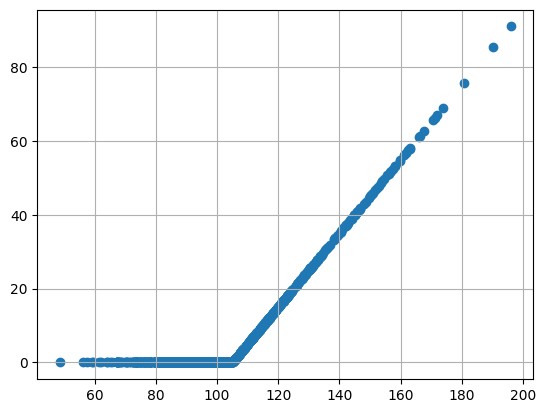

In [6]:
# Scatter plot of the simulated final stock prices vs. option payoffs
plt.scatter(prices[-1],payoff[-1])
plt.grid()
print(option_price)
print(BS_price)

# **Digital call option in BS model**  
In a **digital call option**, the payoff is fixed (e.g., 1 unit of currency) if the stock price is above the strike price at expiration. Unlike a standard call option, a digital call does not scale with the stock price—it either pays out or does not.  

In [7]:
class DigitalCallOption(object):
    def __init__(self, S0, K, r, T, sigma, Q, M, I):
        """
        Initialize the DigitalCallOption class.

        Parameters:
        S0 : Initial stock price
        K : Strike price (threshold price)
        r : Risk-free interest rate
        T : Time to maturity (in years)
        sigma : Volatility
        Q : Fixed payout if the option expires in-the-money
        M : Number of time steps for Monte Carlo simulation
        I : Number of simulation paths (Monte Carlo simulations)
        """
        self.S0 = S0
        self.K = K
        self.r = r
        self.T = T
        self.sigma = sigma
        self.Q = Q
        self.M = M
        self.I = I

    def value(self):
        """
        Calculate the theoretical price of the Digital Call Option using Black-Scholes formula.

        The pricing formula is:
        Value = Q * N(d2) * e^(-rT)

        where:
        d2 = (ln(S0/K) + (r - 0.5 * sigma^2) * T) / (sigma * sqrt(T))

        Returns:
        Theoretical price of the digital call option
        """
        d2 = (np.log(self.S0 / self.K) + (self.r - 0.5 * self.sigma ** 2) * self.T) / (self.sigma * np.sqrt(self.T))
        value = self.Q * s.norm.cdf(d2, 0, 1) * np.exp(-self.r * self.T)
        return value

    def simulation(self):
        """
        Simulate the stock price paths using the Monte Carlo method
        and compute the digital call option payoff.

        If S_T > K (final price > strike), payoff = 1
        Otherwise, payoff = 0

        Returns:
        S : Simulated stock price paths
        payoff : Payoffs (1 or 0 depending on stock price at expiration)
        """
        dt = self.T / self.M
        S = np.zeros((self.M + 1, self.I))
        payoff = np.zeros((self.M + 1, self.I))
        S[0] = self.S0

        for t in range(1, self.M + 1):
            z = np.random.standard_normal(self.I)
            S[t] = S[t - 1] * np.exp((self.r - 0.5 * self.sigma ** 2) * dt + self.sigma * np.sqrt(dt) * z)

            for i in range(self.I):
                if S[t, i] > self.K:
                    payoff[t, i] = 1
                else:
                    payoff[t, i] = 0

        return S, payoff

In [8]:
# Run Monte Carlo simulation to compute option price
prices,payoff = DigitalCallOption(100, 105, 0.05, 1.0, 0.2,5,5000,1000).simulation()
# Compute Monte Carlo estimated option price
option_price = np.sum(payoff[-1])/1000 * 5 * np.exp(-0.05 * 1)
# Compute the Black-Scholes price
BS_price = DigitalCallOption(100, 105, 0.05, 1.0, 0.2,5,5000,1000).value()

2.192583823474146
2.200070529682731


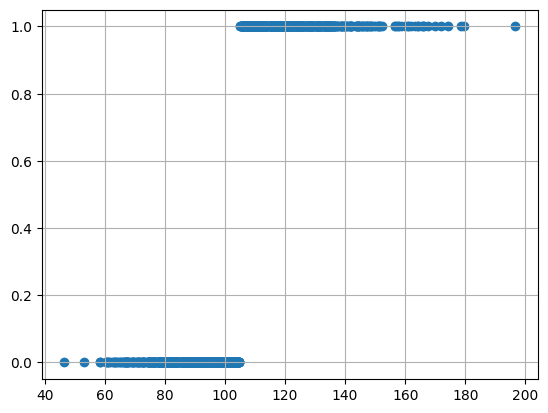

In [9]:
# Scatter plot of the simulated final stock prices vs. option payoffs
plt.scatter(prices[-1],payoff[-1])
plt.grid()
print(option_price)
print(BS_price)

# **BS vs Heston model**

The **Heston Model** is a widely-used **stochastic volatility model** in finance that describes asset price dynamics, where volatility is not constant but instead follows a random process.
- The asset price $S$ follows a **geometric Brownian motion** with volatility evolving over time. The price is given by:
  $$
  dS_t = rS_t dt + \sqrt{v_t} S_t dW_{t}
  $$
  where:
  - $r$ is the risk-free rate,
  - $v$ is the instantaneous volatility (variance) at time $t$,
  - $W$ is a Wiener process for the asset price.

- The volatility $v$ follows a **mean-reverting process**, which is modeled by:
  $$
  dv_t = \kappa(\theta - v_t) dt + \xi \sqrt{v_t} dV_{t}
  $$
  where:
  - $\kappa$ is the speed of mean reversion,
  - $\theta$ is the long-term mean volatility level,
  - $\xi$ is the volatility of volatility,
  - $B$ is a Wiener process for volatility.

- The two processes $W$ and $B$ are **correlated** with a correlation coefficient $\rho$, meaning that changes in asset prices are related to changes in volatility.

In [10]:
class HestonModel(object):
    def __init__(self,S, T, r, kappa, theta, v_0, rho, xi, steps, Npaths):
      self.S = S
      self.v_0 = v_0
      self.T = T
      self.r = r
      self.kappa = kappa
      self.theta = theta
      self.rho = rho
      self.xi = xi
      self.steps = steps
      self.Npaths = Npaths

    def heston_paths(self):
      S_t = self.S
      v_t = self.v_0
      dt = self.T/self.steps
      prices = np.zeros((self.Npaths,self.steps))
      sigs = np.zeros((self.Npaths,self.steps))
      for t in range(self.steps):
        WT = np.random.multivariate_normal(np.array([0,0]),
                                           cov = np.array([[1,self.rho],
                                                          [self.rho,1]]),
                                           size=self.Npaths) * np.sqrt(dt)

        S_t = S_t*(np.exp( (self.r - 0.5* v_t)*dt+ np.sqrt(v_t) *WT[:,0] ) )

        # Enforce that variance remains bigger or equal than 0
        v_t = np.maximum(v_t + self.kappa * (self.theta - np.maximum(v_t, 0)) * dt + self.xi * np.sqrt(np.maximum(v_t, 0)) * WT[:, 1], 0)
        prices[:, t] = S_t
        sigs[:, t] = v_t
      return prices,sigs

In [11]:
# Positive correlation
S_p,V_p = HestonModel(100, 1, 0.02, 4.0, 0.02, 0.02, 0.7, 0.9, 10000, 100).heston_paths()
# Negative correlation
S_n,V_n = HestonModel(100, 1, 0.02, 4.0, 0.02, 0.02, -0.7, 0.9, 10000, 100).heston_paths()

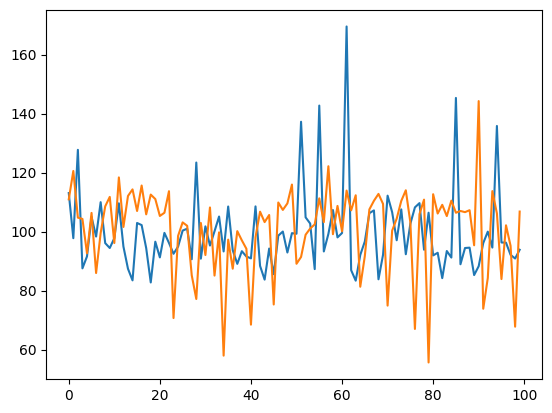

In [12]:
plt.plot(S_p[:,-1])
plt.plot(S_n[:,-1])

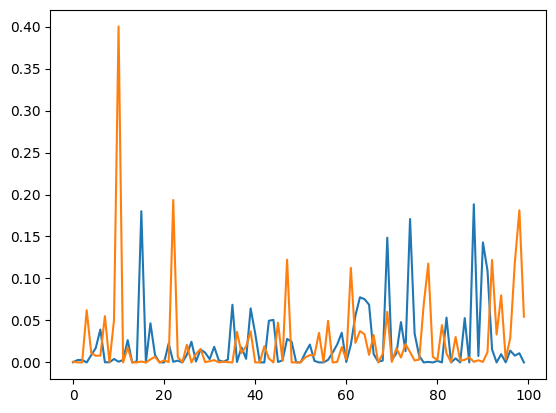

In [ ]:
plt.plot(V_p[:,-1])
plt.plot(V_n[:,-1])

In [13]:
# Simulation of asset prices in BS model
S_gbm, p = DigitalCallOption(100, 105, 0.02, 1.0, 0.2, 5, 5000, 100).simulation()

Text(0, 0.5, 'Density')

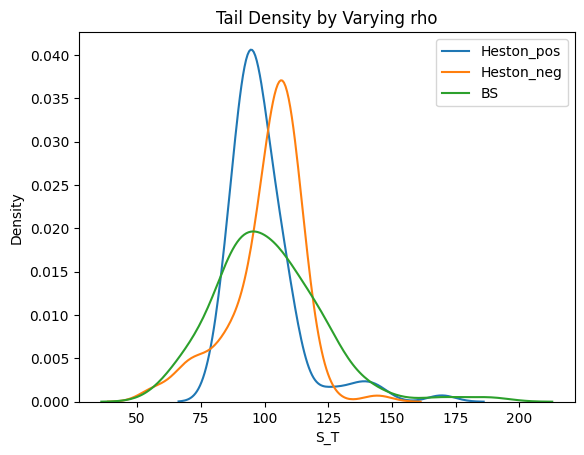

In [14]:
import seaborn as sns

"""
We visualize the probability density of the final asset prices
from different models (Heston model with positive and negative correlations,
and the GBM model for the digital call option).
"""

fig, ax = plt.subplots()

ax = sns.kdeplot(data=S_p[:,-1], label="Heston_pos", ax=ax)
ax = sns.kdeplot(data=S_n[:,-1], label="Heston_neg", ax=ax)
ax = sns.kdeplot(data=S_gbm[-1], label="BS", ax=ax)

ax.set_title(r'Tail Density by Varying rho')
plt.legend()
plt.xlabel('S_T')
plt.ylabel('Density')